## Predict Accident Risk Score for Unique Postcode

### Introduction

The rise in vehicles on the road leads to multiple challenges and the road becomes more vulnerable to accidents.Increased accident rates also leads to more insurance claims and payouts rise for insurance companies.

In order to pre-emptively plan for the losses, the insurance firms leverage accident data to understand the risk across the geographical units e.g. Postal code/district etc.

In this challenge, we are providing you the dataset to predict the “Accident_Risk_Index” against the postcodes.

**Accident_Risk_Index (mean casualties at a postcode) = sum(Number_of_casualities)/count(Accident_ID)**

### EXPLORATORY DATA ANALYSIS

In [1]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Importing Required Datasets
train= pd.read_csv("Desktop/Machine hack/swiss re/train.csv")
test=pd.read_csv("Desktop/Machine hack/swiss re/test.csv")
population=pd.read_csv("Desktop/Machine hack/swiss re/population.csv")
roads_network=pd.read_csv("Desktop/Machine hack/swiss re/roads_network.csv")
sample_submission=pd.read_csv("Desktop/Machine hack/swiss re/sample_submission.csv")

In [3]:
train.head()

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,state,postcode,country
0,1,34,2,1,19/12/12,7,13:20,344,E10000032,4,...,Daylight: Street light present,Fine without high winds,Dry,Ol or diesel,None,1,Yes,England,OX3 9UP,United Kingdom
1,2,5,2,1,02/11/12,4,7:53,102,E09000026,3,...,Daylight: Street light present,Raining without high winds,Dry,None,None,1,No,England,S35 4EZ,United Kingdom
2,3,1,2,1,02/11/12,4,16:00,531,E10000016,6,...,Daylight: Street light present,Fine without high winds,Dry,None,None,1,No,England,BN21 2XR,United Kingdom
3,4,1,1,1,06/05/12,1,16:50,7,E08000035,6,...,Daylight: Street light present,Fine without high winds,Dry,Roadworks,None,1,Yes,England,TA20 3PT,United Kingdom
4,5,46,1,1,30/06/12,3,13:25,519,E10000031,3,...,Daylight: Street light present,Fine without high winds,Dry,None,None,1,No,England,DN20 0QF,United Kingdom


In [4]:
#Checking for null values
train.isnull().sum(),test.isnull().sum()

(Accident_ID                                      0
 Police_Force                                     0
 Number_of_Vehicles                               0
 Number_of_Casualties                             0
 Date                                             0
 Day_of_Week                                      0
 Time                                            14
 Local_Authority_(District)                       0
 Local_Authority_(Highway)                        0
 1st_Road_Class                                   0
 1st_Road_Number                                  0
 Road_Type                                        0
 Speed_limit                                      0
 2nd_Road_Class                                   0
 2nd_Road_Number                                  0
 Pedestrian_Crossing-Human_Control                0
 Pedestrian_Crossing-Physical_Facilities          0
 Light_Conditions                                 0
 Weather_Conditions                               0
 Road_Surfac

In [5]:
# Replacing Null Values with the Mode Value
train['Road_Surface_Conditions'].fillna(train['Road_Surface_Conditions'].mode()[0], inplace=True)
test['Road_Surface_Conditions'].fillna(train['Road_Surface_Conditions'].mode()[0], inplace=True)
train['Special_Conditions_at_Site'].fillna(train['Special_Conditions_at_Site'].mode()[0], inplace=True)
test['Special_Conditions_at_Site'].fillna(train['Special_Conditions_at_Site'].mode()[0], inplace=True)
train['Time'].fillna(train['Time'].mode()[0], inplace=True)
test['Time'].fillna(train['Time'].mode()[0], inplace=True)

In [6]:
train.dtypes

Accident_ID                                     int64
Police_Force                                    int64
Number_of_Vehicles                              int64
Number_of_Casualties                            int64
Date                                           object
Day_of_Week                                     int64
Time                                           object
Local_Authority_(District)                      int64
Local_Authority_(Highway)                      object
1st_Road_Class                                  int64
1st_Road_Number                                 int64
Road_Type                                      object
Speed_limit                                     int64
2nd_Road_Class                                  int64
2nd_Road_Number                                 int64
Pedestrian_Crossing-Human_Control              object
Pedestrian_Crossing-Physical_Facilities        object
Light_Conditions                               object
Weather_Conditions          

In [7]:
categorical_columns=['Day_of_Week','Local_Authority_(District)',                            
'Local_Authority_(Highway)',                              
'1st_Road_Class',                                     
'1st_Road_Number',                                         
'Road_Type',                                              
'Speed_limit',                                            
'2nd_Road_Class',                                          
'2nd_Road_Number',                                         
'Pedestrian_Crossing-Human_Control',                      
'Pedestrian_Crossing-Physical_Facilities',                
'Light_Conditions',                                       
'Weather_Conditions',                                     
'Road_Surface_Conditions',                                
'Special_Conditions_at_Site',                             
'Carriageway_Hazards',                                    
'Urban_or_Rural_Area' ,                                    
'Did_Police_Officer_Attend_Scene_of_Accident',            
'state',                                                  
'postcode',                                               
'country']

In [8]:
train[categorical_columns]=train[categorical_columns].astype('category')
test[categorical_columns]=test[categorical_columns].astype('category')

In [9]:
#Converting Date and Time columns into Datetime format
train['Date']=pd.to_datetime(train['Date'])

In [10]:
train['Time']=pd.to_datetime(train['Time'])

In [11]:
#Converting Date and time for test dataset also
test['Date']=pd.to_datetime(test['Date'])
test['Time']=pd.to_datetime(test['Time'])


In [12]:
#Adding Month and Hour columns

train['Month']=train['Date'].dt.month
test['Month']=test['Date'].dt.month

train['Hour']=train['Time'].dt.hour
test['Hour']=test['Time'].dt.hour

In [13]:
train.head()

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,state,postcode,country,Month,Hour
0,1,34,2,1,2012-12-19,7,2022-03-28 13:20:00,344,E10000032,4,...,Dry,Ol or diesel,None,1,Yes,England,OX3 9UP,United Kingdom,12,13
1,2,5,2,1,2012-02-11,4,2022-03-28 07:53:00,102,E09000026,3,...,Dry,None,None,1,No,England,S35 4EZ,United Kingdom,2,7
2,3,1,2,1,2012-02-11,4,2022-03-28 16:00:00,531,E10000016,6,...,Dry,None,None,1,No,England,BN21 2XR,United Kingdom,2,16
3,4,1,1,1,2012-06-05,1,2022-03-28 16:50:00,7,E08000035,6,...,Dry,Roadworks,None,1,Yes,England,TA20 3PT,United Kingdom,6,16
4,5,46,1,1,2012-06-30,3,2022-03-28 13:25:00,519,E10000031,3,...,Dry,None,None,1,No,England,DN20 0QF,United Kingdom,6,13


In [14]:
train.describe()

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Month,Hour
count,478741.000000,478741.000000,478741.000000,478741.000000,478741.000000,478741.000000
mean,299892.954673,31.610178,1.745695,1.463528,5.815487,13.861489
std,173261.274950,24.941660,0.626458,0.816019,3.429698,4.669765
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,149718.000000,12.000000,1.000000,1.000000,3.000000,11.000000
50%,299791.000000,33.000000,2.000000,1.000000,6.000000,14.000000
75%,449990.000000,45.000000,2.000000,2.000000,9.000000,17.000000
max,599999.000000,98.000000,4.000000,5.000000,12.000000,23.000000


In [15]:
categorical_columns.extend(['Month','Hour'])


In [16]:
categorical_columns

['Day_of_Week',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 '1st_Road_Number',
 'Road_Type',
 'Speed_limit',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'state',
 'postcode',
 'country',
 'Month',
 'Hour']

In [17]:
numerical_columns=['Police_Force','Number_of_Vehicles','Number_of_Casualties']

In [18]:
#correlation analysis of numerical variables
train[numerical_columns].corr()

,Police_Force,Number_of_Vehicles,Number_of_Casualties
Police_Force,1.000000,-0.051907,-0.003210
Number_of_Vehicles,-0.051907,1.000000,0.031821
Number_of_Casualties,-0.003210,0.031821,1.000000


**Observation:-** Number of casualties is *slightly positive* correlated with Number of Vehicles
Number of casualties is *slightly negative* correlated with Police Force available    

#### Univariate Analysis of Categorical variables

Text(0, 0.5, 'average_casualties')

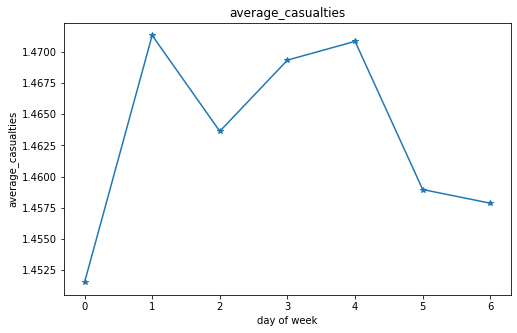

In [19]:
avg_casualties_day = train.groupby(['Day_of_Week'])['Number_of_Casualties'].mean().reset_index().rename(columns = {'Number_of_Casualties':'avg_casualties'})
plt.figure(figsize = (8, 5))
plt.plot(avg_casualties_day['avg_casualties'],'*-')
plt.title('average_casualties')
plt.xlabel('day of week')
plt.ylabel('average_casualties')

Text(0, 0.5, 'average_casualties')

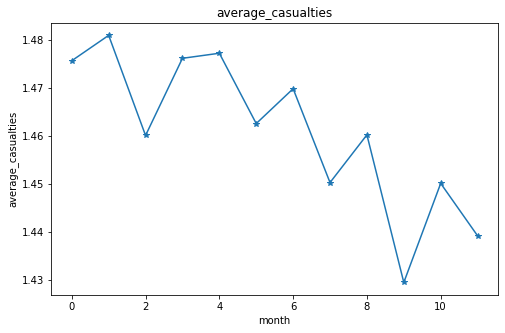

In [20]:
avg_casualties_month = train.groupby(['Month'])['Number_of_Casualties'].mean().reset_index().rename(columns = {'Number_of_Casualties':'avg_casualties'})
plt.figure(figsize = (8, 5))
plt.plot(avg_casualties_month['avg_casualties'],'*-')
plt.title('average_casualties')
plt.xlabel('month')
plt.ylabel('average_casualties')

In [21]:
mean_encode=train.groupby('Day_of_Week')['Number_of_Casualties'].mean()
print(mean_encode)
train.loc[:,'Day_of_Week_mean_enc']=train['Day_of_Week'].map(mean_encode)
train

Day_of_Week
1    1.451505
2    1.471335
3    1.463637
4    1.469348
5    1.470855
6    1.458962
7    1.457864
Name: Number_of_Casualties, dtype: float64


,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,state,postcode,country,Month,Hour,Day_of_Week_mean_enc
0,1,34,2,1,2012-12-19,7,2022-03-28 13:20:00,344,E10000032,4,...,Ol or diesel,None,1,Yes,England,OX3 9UP,United Kingdom,12,13,1.457864
1,2,5,2,1,2012-02-11,4,2022-03-28 07:53:00,102,E09000026,3,...,None,None,1,No,England,S35 4EZ,United Kingdom,2,7,1.469348
2,3,1,2,1,2012-02-11,4,2022-03-28 16:00:00,531,E10000016,6,...,None,None,1,No,England,BN21 2XR,United Kingdom,2,16,1.469348
3,4,1,1,1,2012-06-05,1,2022-03-28 16:50:00,7,E08000035,6,...,Roadworks,None,1,Yes,England,TA20 3PT,United Kingdom,6,16,1.451505
4,5,46,1,1,2012-06-30,3,2022-03-28 13:25:00,519,E10000031,3,...,None,None,1,No,England,DN20 0QF,United Kingdom,6,13,1.463637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478736,599995,13,1,1,2012-09-28,6,2022-03-28 16:35:00,199,E10000015,6,...,None,None,2,Yes,England,E12 6EA,United Kingdom,9,16,1.458962
478737,599996,13,2,1,2012-01-23,4,2022-03-28 20:45:00,211,E09000012,6,...,None,None,1,No,England,NN2 8PF,United Kingdom,1,20,1.469348
478738,599997,6,2,4,2012-05-15,6,2022-03-28 10:45:00,80,E06000047,3,...,None,None,1,No,England,DN36 5FR,United Kingdom,5,10,1.458962
478739,599998,33,2,1,2012-09-10,2,2022-03-28 11:22:00,321,E10000024,3,...,None,Other object in carriageway,2,No,England,BN11 2EB,United Kingdom,9,11,1.471335


In [22]:
for i in categorical_columns:
    mean_encode=train.groupby(i)['Number_of_Casualties'].mean()
    print(mean_encode)
    train.loc[:,'{}_mean_enc'.format(i)]=train[i].map(mean_encode)
train

Day_of_Week
1    1.451505
2    1.471335
3    1.463637
4    1.469348
5    1.470855
6    1.458962
7    1.457864
Name: Number_of_Casualties, dtype: float64
Local_Authority_(District)
1      1.361831
2      1.000000
3      1.196891
4      1.234122
5      1.275419
         ...   
937    1.425044
938    1.426471
939    1.427570
940    1.473822
941    1.385873
Name: Number_of_Casualties, Length: 880, dtype: float64
Local_Authority_(Highway)
E06000001    1.516010
E06000002    1.406667
E06000003    1.443620
E06000004    1.490605
E06000005    1.475037
               ...   
W06000020    1.472222
W06000021    1.430493
W06000022    1.487943
W06000023    1.488192
W06000024    1.531390
Name: Number_of_Casualties, Length: 207, dtype: float64
1st_Road_Class
1    1.519145
3    1.510667
4    1.483307
5    1.445391
6    1.408041
Name: Number_of_Casualties, dtype: float64
1st_Road_Number
0       1.396638
1       1.414293
2       1.400828
3       1.412766
4       1.412893
          ...   
9805    1.000000
9

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Road_Surface_Conditions_mean_enc,Special_Conditions_at_Site_mean_enc,Carriageway_Hazards_mean_enc,Urban_or_Rural_Area_mean_enc,Did_Police_Officer_Attend_Scene_of_Accident_mean_enc,state_mean_enc,postcode_mean_enc,country_mean_enc,Month_mean_enc,Hour_mean_enc
0,1,34,2,1,2012-12-19,7,2022-03-28 13:20:00,344,E10000032,4,...,1.468699,1.532458,1.462916,1.436462,1.467317,1.461549,1.833333,1.463528,1.439151,1.470946
1,2,5,2,1,2012-02-11,4,2022-03-28 07:53:00,102,E09000026,3,...,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.333333,1.463528,1.480904,1.466181
2,3,1,2,1,2012-02-11,4,2022-03-28 16:00:00,531,E10000016,6,...,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.333333,1.463528,1.480904,1.462673
3,4,1,1,1,2012-06-05,1,2022-03-28 16:50:00,7,E08000035,6,...,1.468699,1.458057,1.462916,1.436462,1.467317,1.461549,1.666667,1.463528,1.462532,1.462673
4,5,46,1,1,2012-06-30,3,2022-03-28 13:25:00,519,E10000031,3,...,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.500000,1.463528,1.462532,1.470946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478736,599995,13,1,1,2012-09-28,6,2022-03-28 16:35:00,199,E10000015,6,...,1.474980,1.463347,1.462916,1.503782,1.467317,1.461549,1.428571,1.463528,1.460182,1.462673
478737,599996,13,2,1,2012-01-23,4,2022-03-28 20:45:00,211,E09000012,6,...,1.438232,1.463347,1.462916,1.436462,1.446628,1.461549,1.166667,1.463528,1.475618,1.450637
478738,599997,6,2,4,2012-05-15,6,2022-03-28 10:45:00,80,E06000047,3,...,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.923077,1.463528,1.477179,1.468014
478739,599998,33,2,1,2012-09-10,2,2022-03-28 11:22:00,321,E10000024,3,...,1.468699,1.463347,1.479170,1.503782,1.446628,1.461549,1.555556,1.463528,1.460182,1.466242


In [23]:
for i in categorical_columns:
    mean_encode=train.groupby(i)['Number_of_Casualties'].mean()
    test.loc[:,'{}_mean_enc'.format(i)]=test[i].map(mean_encode)
test

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Road_Surface_Conditions_mean_enc,Special_Conditions_at_Site_mean_enc,Carriageway_Hazards_mean_enc,Urban_or_Rural_Area_mean_enc,Did_Police_Officer_Attend_Scene_of_Accident_mean_enc,state_mean_enc,postcode_mean_enc,country_mean_enc,Month_mean_enc,Hour_mean_enc
0,14,13,2,0,2013-06-10,6,2022-03-28 13:28:00,218,E10000032,4,...,1.468699,1.463347,1.462916,1.503782,1.467317,1.461549,2.000000,1.463528,1.462532,1.470946
1,17,13,2,0,2013-04-22,7,2022-03-28 09:30:00,157,E10000034,6,...,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.500000,1.463528,1.476125,1.463114
2,21,13,2,0,2013-09-27,3,2022-03-28 19:10:00,155,E09000012,3,...,1.438232,1.463347,1.462916,1.436462,1.467317,1.461549,1.000000,1.463528,1.460182,1.459780
3,23,13,2,0,2013-03-13,4,2022-03-28 09:19:00,26,E10000016,4,...,1.468699,1.463347,1.462916,1.436462,1.467317,1.461549,1.000000,1.463528,1.460049,1.463114
4,28,14,2,0,2013-06-13,1,2022-03-28 14:59:00,6,E08000012,4,...,1.468699,1.463347,1.462916,1.436462,1.467317,1.461549,1.000000,1.463528,1.462532,1.465019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121254,599986,1,2,0,2013-05-07,5,2022-03-28 18:31:00,6,E06000042,6,...,1.438232,1.463347,1.462916,1.436462,1.467317,1.461549,1.333333,1.463528,1.477179,1.468574
121255,599990,62,2,0,2013-11-22,6,2022-03-28 07:40:00,633,W06000004,3,...,1.438232,1.463347,1.462916,1.436462,1.467317,1.483215,1.571429,1.463528,1.450072,1.466181
121256,599991,13,2,0,2013-12-10,6,2022-03-28 08:26:00,143,E10000034,3,...,1.468699,1.458057,1.462916,1.503782,1.467317,1.461549,3.000000,1.463528,1.439151,1.462732
121257,599993,1,2,0,2013-05-06,5,2022-03-28 22:54:00,7,E09000016,6,...,1.438232,1.458057,1.462916,1.436462,1.467317,1.461549,1.000000,1.463528,1.477179,1.461796


In [24]:
train1=train.drop(categorical_columns,axis=1)
test1=test.drop(categorical_columns,axis=1)

In [25]:
train1=train1.drop(['Accident_ID','Date','Time','postcode_mean_enc'],axis=1)
test1=test1.drop(['Accident_ID','Date','Time','postcode_mean_enc'],axis=1)

In [26]:
train1.head()

,Police_Force,Number_of_Vehicles,Number_of_Casualties,Day_of_Week_mean_enc,Local_Authority_(District)_mean_enc,Local_Authority_(Highway)_mean_enc,1st_Road_Class_mean_enc,1st_Road_Number_mean_enc,Road_Type_mean_enc,Speed_limit_mean_enc,...,Weather_Conditions_mean_enc,Road_Surface_Conditions_mean_enc,Special_Conditions_at_Site_mean_enc,Carriageway_Hazards_mean_enc,Urban_or_Rural_Area_mean_enc,Did_Police_Officer_Attend_Scene_of_Accident_mean_enc,state_mean_enc,country_mean_enc,Month_mean_enc,Hour_mean_enc
0,34,2,1,1.457864,1.496403,1.486570,1.483307,1.489292,1.452992,1.436286,...,1.466949,1.468699,1.532458,1.462916,1.436462,1.467317,1.461549,1.463528,1.439151,1.470946
1,5,2,1,1.469348,1.454724,1.482533,1.510667,1.440469,1.486981,1.436286,...,1.443230,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.480904,1.466181
2,1,2,1,1.469348,1.411504,1.416494,1.408041,1.421996,1.502190,1.558461,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.480904,1.462673
3,1,1,1,1.451505,1.340034,1.439101,1.408041,1.440469,1.452992,1.436286,...,1.466949,1.468699,1.458057,1.462916,1.436462,1.467317,1.461549,1.463528,1.462532,1.462673
4,46,1,1,1.463637,1.363971,1.464855,1.510667,1.347530,1.506754,1.436286,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.462532,1.470946


In [27]:
test1.head()

,Police_Force,Number_of_Vehicles,Number_of_Casualties,Day_of_Week_mean_enc,Local_Authority_(District)_mean_enc,Local_Authority_(Highway)_mean_enc,1st_Road_Class_mean_enc,1st_Road_Number_mean_enc,Road_Type_mean_enc,Speed_limit_mean_enc,...,Weather_Conditions_mean_enc,Road_Surface_Conditions_mean_enc,Special_Conditions_at_Site_mean_enc,Carriageway_Hazards_mean_enc,Urban_or_Rural_Area_mean_enc,Did_Police_Officer_Attend_Scene_of_Accident_mean_enc,state_mean_enc,country_mean_enc,Month_mean_enc,Hour_mean_enc
0,13,2,0,1.458962,1.372340,1.486570,1.483307,1.653846,1.452992,1.495621,...,1.456380,1.468699,1.463347,1.462916,1.503782,1.467317,1.461549,1.463528,1.462532,1.470946
1,13,2,0,1.457864,1.676829,1.413648,1.408041,1.230769,1.452992,1.436286,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.476125,1.463114
2,13,2,0,1.463637,1.506494,1.503634,1.510667,1.363636,1.502190,1.558461,...,1.466949,1.438232,1.463347,1.462916,1.436462,1.467317,1.461549,1.463528,1.460182,1.459780
3,13,2,0,1.469348,1.344099,1.416494,1.483307,1.395522,1.452992,1.436286,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.467317,1.461549,1.463528,1.460049,1.463114
4,14,2,0,1.451505,1.289716,1.414409,1.483307,1.475524,1.452992,1.436286,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.467317,1.461549,1.463528,1.462532,1.465019


In [28]:
y=train['Number_of_Casualties']

In [29]:
train1=train1.drop('Number_of_Casualties',axis=1)
test1=test1.drop('Number_of_Casualties',axis=1)

In [30]:
train1.head()

,Police_Force,Number_of_Vehicles,Day_of_Week_mean_enc,Local_Authority_(District)_mean_enc,Local_Authority_(Highway)_mean_enc,1st_Road_Class_mean_enc,1st_Road_Number_mean_enc,Road_Type_mean_enc,Speed_limit_mean_enc,2nd_Road_Class_mean_enc,...,Weather_Conditions_mean_enc,Road_Surface_Conditions_mean_enc,Special_Conditions_at_Site_mean_enc,Carriageway_Hazards_mean_enc,Urban_or_Rural_Area_mean_enc,Did_Police_Officer_Attend_Scene_of_Accident_mean_enc,state_mean_enc,country_mean_enc,Month_mean_enc,Hour_mean_enc
0,34,2,1.457864,1.496403,1.486570,1.483307,1.489292,1.452992,1.436286,1.475386,...,1.466949,1.468699,1.532458,1.462916,1.436462,1.467317,1.461549,1.463528,1.439151,1.470946
1,5,2,1.469348,1.454724,1.482533,1.510667,1.440469,1.486981,1.436286,1.475386,...,1.443230,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.480904,1.466181
2,1,2,1.469348,1.411504,1.416494,1.408041,1.421996,1.502190,1.558461,1.426148,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.480904,1.462673
3,1,1,1.451505,1.340034,1.439101,1.408041,1.440469,1.452992,1.436286,1.426148,...,1.466949,1.468699,1.458057,1.462916,1.436462,1.467317,1.461549,1.463528,1.462532,1.462673
4,46,1,1.463637,1.363971,1.464855,1.510667,1.347530,1.506754,1.436286,1.426148,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.462532,1.470946


In [31]:
test1.head()

,Police_Force,Number_of_Vehicles,Day_of_Week_mean_enc,Local_Authority_(District)_mean_enc,Local_Authority_(Highway)_mean_enc,1st_Road_Class_mean_enc,1st_Road_Number_mean_enc,Road_Type_mean_enc,Speed_limit_mean_enc,2nd_Road_Class_mean_enc,...,Weather_Conditions_mean_enc,Road_Surface_Conditions_mean_enc,Special_Conditions_at_Site_mean_enc,Carriageway_Hazards_mean_enc,Urban_or_Rural_Area_mean_enc,Did_Police_Officer_Attend_Scene_of_Accident_mean_enc,state_mean_enc,country_mean_enc,Month_mean_enc,Hour_mean_enc
0,13,2,1.458962,1.372340,1.486570,1.483307,1.653846,1.452992,1.495621,1.426148,...,1.456380,1.468699,1.463347,1.462916,1.503782,1.467317,1.461549,1.463528,1.462532,1.470946
1,13,2,1.457864,1.676829,1.413648,1.408041,1.230769,1.452992,1.436286,1.475386,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.476125,1.463114
2,13,2,1.463637,1.506494,1.503634,1.510667,1.363636,1.502190,1.558461,1.506608,...,1.466949,1.438232,1.463347,1.462916,1.436462,1.467317,1.461549,1.463528,1.460182,1.459780
3,13,2,1.469348,1.344099,1.416494,1.483307,1.395522,1.452992,1.436286,1.475386,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.467317,1.461549,1.463528,1.460049,1.463114
4,14,2,1.451505,1.289716,1.414409,1.483307,1.475524,1.452992,1.436286,1.506608,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.467317,1.461549,1.463528,1.462532,1.465019


In [32]:
test1.isnull().sum()

Police_Force                                              0
Number_of_Vehicles                                        0
Day_of_Week_mean_enc                                      0
Local_Authority_(District)_mean_enc                       3
Local_Authority_(Highway)_mean_enc                        0
1st_Road_Class_mean_enc                                   0
1st_Road_Number_mean_enc                                546
Road_Type_mean_enc                                        0
Speed_limit_mean_enc                                      0
2nd_Road_Class_mean_enc                                   0
2nd_Road_Number_mean_enc                                  0
Pedestrian_Crossing-Human_Control_mean_enc                0
Pedestrian_Crossing-Physical_Facilities_mean_enc          0
Light_Conditions_mean_enc                                 0
Weather_Conditions_mean_enc                               0
Road_Surface_Conditions_mean_enc                          0
Special_Conditions_at_Site_mean_enc     

In [33]:
##train1=train1.drop(['Local_Authority_(District)_mean_enc','1st_Road_Number_mean_enc'],axis=1)
##test1=test1.drop(['Local_Authority_(District)_mean_enc','1st_Road_Number_mean_enc'],axis=1)                     

In [34]:
train1.head()

,Police_Force,Number_of_Vehicles,Day_of_Week_mean_enc,Local_Authority_(District)_mean_enc,Local_Authority_(Highway)_mean_enc,1st_Road_Class_mean_enc,1st_Road_Number_mean_enc,Road_Type_mean_enc,Speed_limit_mean_enc,2nd_Road_Class_mean_enc,...,Weather_Conditions_mean_enc,Road_Surface_Conditions_mean_enc,Special_Conditions_at_Site_mean_enc,Carriageway_Hazards_mean_enc,Urban_or_Rural_Area_mean_enc,Did_Police_Officer_Attend_Scene_of_Accident_mean_enc,state_mean_enc,country_mean_enc,Month_mean_enc,Hour_mean_enc
0,34,2,1.457864,1.496403,1.486570,1.483307,1.489292,1.452992,1.436286,1.475386,...,1.466949,1.468699,1.532458,1.462916,1.436462,1.467317,1.461549,1.463528,1.439151,1.470946
1,5,2,1.469348,1.454724,1.482533,1.510667,1.440469,1.486981,1.436286,1.475386,...,1.443230,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.480904,1.466181
2,1,2,1.469348,1.411504,1.416494,1.408041,1.421996,1.502190,1.558461,1.426148,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.480904,1.462673
3,1,1,1.451505,1.340034,1.439101,1.408041,1.440469,1.452992,1.436286,1.426148,...,1.466949,1.468699,1.458057,1.462916,1.436462,1.467317,1.461549,1.463528,1.462532,1.462673
4,46,1,1.463637,1.363971,1.464855,1.510667,1.347530,1.506754,1.436286,1.426148,...,1.466949,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.463528,1.462532,1.470946


In [44]:
test1[['Local_Authority_(District)_mean_enc','1st_Road_Number_mean_enc']]=test1[['Local_Authority_(District)_mean_enc','1st_Road_Number_mean_enc']].fillna(0)

### TRAIN TEST SPLIT AND MODELLING

In [35]:
xtrain_1,xval_1,ytrain,yval=train_test_split(train1,y,test_size=0.3,random_state=11)

In [36]:
model=LinearRegression(normalize=True)

In [37]:
model.fit(xtrain_1,ytrain)
pred_1=model.predict(xval_1)

In [38]:
mean_squared_error(yval,pred_1)

0.6511389874913875

In [45]:
predtest_1=model.predict(test1)

In [47]:
test['Number_of_Casualties']=predtest_1

In [48]:
test['Number_of_Casualties'].head()

0    1.600497
1    1.379057
2    1.486964
3    1.288603
4    1.301505
Name: Number_of_Casualties, dtype: float64

In [49]:
test.head()

,Accident_ID,Police_Force,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,...,Road_Surface_Conditions_mean_enc,Special_Conditions_at_Site_mean_enc,Carriageway_Hazards_mean_enc,Urban_or_Rural_Area_mean_enc,Did_Police_Officer_Attend_Scene_of_Accident_mean_enc,state_mean_enc,postcode_mean_enc,country_mean_enc,Month_mean_enc,Hour_mean_enc
0,14,13,2,1.600497,2013-06-10,6,2022-03-28 13:28:00,218,E10000032,4,...,1.468699,1.463347,1.462916,1.503782,1.467317,1.461549,2.0,1.463528,1.462532,1.470946
1,17,13,2,1.379057,2013-04-22,7,2022-03-28 09:30:00,157,E10000034,6,...,1.468699,1.463347,1.462916,1.436462,1.446628,1.461549,1.5,1.463528,1.476125,1.463114
2,21,13,2,1.486964,2013-09-27,3,2022-03-28 19:10:00,155,E09000012,3,...,1.438232,1.463347,1.462916,1.436462,1.467317,1.461549,1.0,1.463528,1.460182,1.459780
3,23,13,2,1.288603,2013-03-13,4,2022-03-28 09:19:00,26,E10000016,4,...,1.468699,1.463347,1.462916,1.436462,1.467317,1.461549,1.0,1.463528,1.460049,1.463114
4,28,14,2,1.301505,2013-06-13,1,2022-03-28 14:59:00,6,E08000012,4,...,1.468699,1.463347,1.462916,1.436462,1.467317,1.461549,1.0,1.463528,1.462532,1.465019


In [51]:
sample_submission.head()

,postcode,Accident_risk_index
0,AB10 1AU,0
1,AB10 1PG,0
2,AB10 1TT,0
3,AB10 1YP,0
4,AB10 6LQ,0


In [55]:
test.to_csv('Desktop/testlr.csv',index=False)